# Summary

This notebook provides a breath of all the features offered in the project. 

# Imports/Setup

In [1]:
from Data import dataset, generator
from Data import utility as data_utility
from Evaluation import utility as eval_utility
from Model import linear, scipy
from Model import utility as model_utility
from Objectives import losses

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

This configuration class is the central control for the training process.

In [2]:
class Config:
    # dataset
    batch_size = 32
    gen_size = 5
    mat_size = 5**2
    seed = 42
    
    # dataloader
    train_len = 1000
    valid_len = 100
    shuffle = True
    
    # device
    device_pref = 'cuda'
    device_ind = 1
    
    # model
    hidden = 128 # 128 for LU (it doubles the amount of layers) | 512 for NID it has larger output same layers | 256 else
    sparse_tol = 1e-5
    diagonal_bias = 0.1
    
    # loss
    l1 =  0
    inv = 0
    dev = 0
    cond = 1.0
    
    # training
    epoches = 100
    lr = 1e-5
    verbose = False
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing_2.pth'
    
    # model save/load
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing_2.pth'
    
    # train save/load
    log_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs_2.npz'

# Dataset/Dataloader

There are two different provided test cases, one SPD and the other NID.

In [3]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

In [4]:
train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [5]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

In [6]:
train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [7]:
A, b = next(iter(train_dataloader))

Determinent: 1201290240.0
Matrix is non-singular.
Condition: 5418.88037109375
SPD


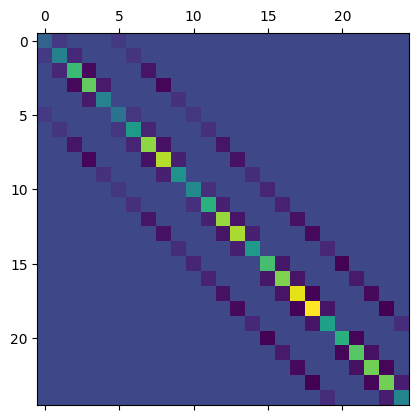

In [10]:
ind = 0
data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind)
print('SPD') if data_utility.is_spd(A, ind) else print('Non-SPD')

# Device

Gather the device.

In [11]:
device_params = {
    'device_pref': Config.device_pref,
    'ind_dev': Config.device_ind
}

In [12]:
device = data_utility.set_device(**device_params)

Now using GPU.


# Model

The primary driver is a linear model. Our setup allows for easy swappout as long as the model ouputs a batch of preconditioners.

In [13]:
model_params = {
    'n':Config.mat_size,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':Config.diagonal_bias
}

In [14]:
model = linear.LuFCN(**model_params).to(device)

# Loss Function

We use loss function that combines many different objective functions. This can easy be swapped out for faster and most stable training but we use this primarily for use in the hyperparameter tuning phase.

In [15]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.mat_size
}

In [16]:
criterion = losses.CondEyeDistance(**loss_params)

# Training

The training block. We also gather training results.

In [17]:
training_params = {
    'epoches': Config.epoches,
    'criterion': criterion,
    'train_loader': train_dataloader,
    'valid_loader': valid_dataloader,
    'model': model,
    'lr': Config.lr,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'verbose': Config.verbose,
    'file_path': Config.file_path
}

In [42]:
train_log, valid_log = model_utility.shared_training_loop(**training_params)

Epoch: 0, Train: 6.007540770053864, Valid: 3.704412338733673
Epoch: 1, Train: 3.0752861008644103, Valid: 2.6564652562141418
Epoch: 2, Train: 2.4281089041233064, Valid: 2.2073038101196287
Epoch: 3, Train: 2.086027591109276, Valid: 1.9475414478778839
Epoch: 4, Train: 1.8831199016571045, Valid: 1.85662140250206
Epoch: 5, Train: 1.751909101486206, Valid: 1.7504653358459472
Epoch: 6, Train: 1.6740047751665115, Valid: 1.6286305153369904
Epoch: 7, Train: 1.6170119005441665, Valid: 1.5841882407665253
Epoch: 8, Train: 1.5779209926128388, Valid: 1.548000328540802
Epoch: 9, Train: 1.5538137819766997, Valid: 1.5434745097160338
Epoch: 10, Train: 1.5214005925655365, Valid: 1.490867373943329
Epoch: 11, Train: 1.5060529861450196, Valid: 1.4754192018508911
Epoch: 12, Train: 1.4976835114955902, Valid: 1.5238591194152833
Epoch: 13, Train: 1.4838206858634948, Valid: 1.4593875527381897
Epoch: 14, Train: 1.4756577138900757, Valid: 1.4507462656497956
Epoch: 15, Train: 1.4513356544971465, Valid: 1.44620566487

# Evaluation

We provide many quantitative and qualitative outlets to assess training strength.

In [43]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'EX', 
    'file_path': 'plt.png'
}

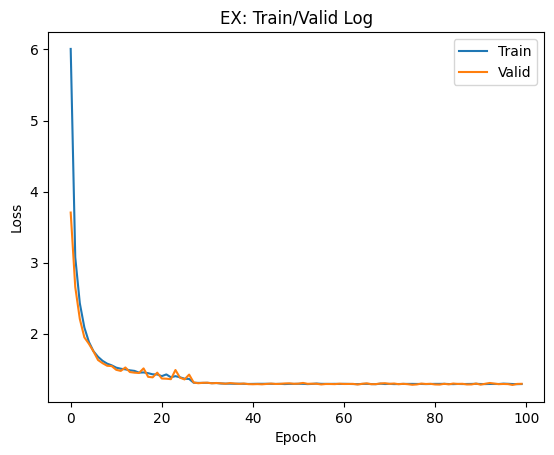

In [44]:
eval_utility.plot_training(**plot_training_params)

In [45]:
eval_instance_params = {
    'A': next(iter(valid_dataloader))[0],
    'model': model,
    'ind': 0,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'criterion': criterion,
    'file_path': 'ex_3.png'
}

Loss: 1.2808467149734497
Inner DET: 2.9807081247668066e-09
Output min: -10.600137710571289


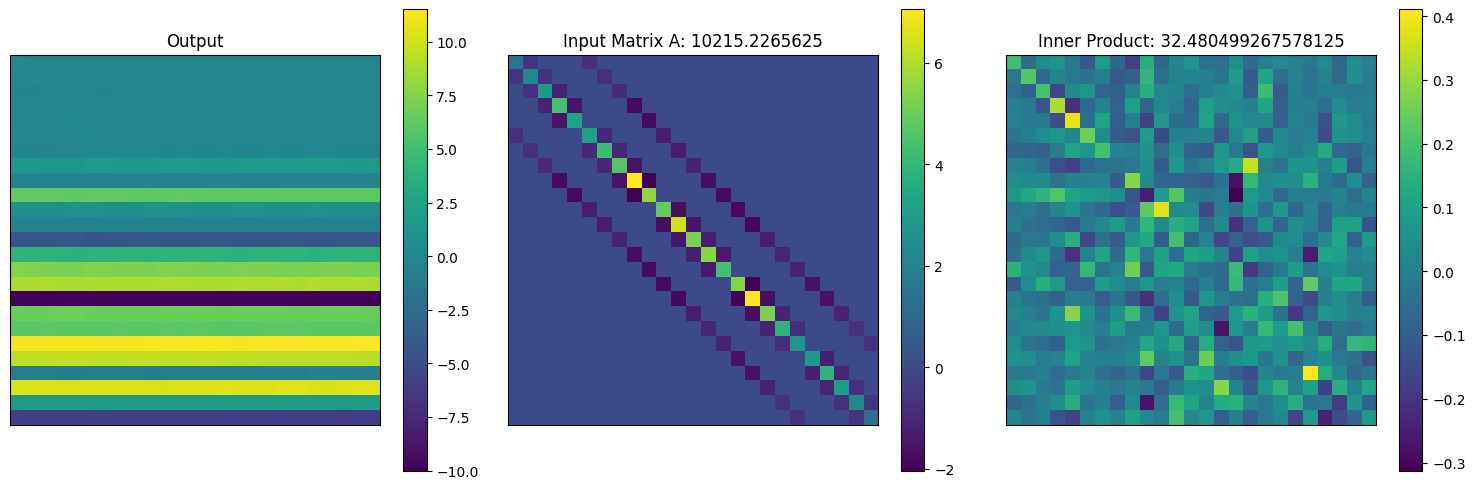

In [46]:
eval_utility.inspect_instance(**eval_instance_params)

In [52]:
import torch
from scipy.sparse.linalg import LinearOperator, cg, gmres
import numpy as np

As = next(iter(valid_dataloader))[0].view(32, 25*25).to(device)

model.eval()
with torch.no_grad():
    out = model(As)[0]
    
A, b = As[0].view(25, 25).cpu().numpy(), torch.randn(25).numpy()
P = out.cpu().numpy()

# cg for guranteed SPD, gmres else

x, info = gmres(A, b, M=P, rtol=1e-8, maxiter=25)
pnorm = np.linalg.norm(A @ x - b)
print('Preconditioned', pnorm, info)

x, info = gmres(A, b, rtol=1e-8, maxiter=25)
bnorm = np.linalg.norm(A @ x - b)
print('Base', bnorm, info)

print('Preconditioned wins!' if pnorm < bnorm else 'Base Wins!')

Preconditioned 0.013709782 25
Base 7.853195e-05 25
Base Wins!


# Model Save/Load

Our built in saving functions. They use the standard torch api.

In [21]:
model_utility.save_model(model, Config.file_path)

In [22]:
model_utility.load_model(model, Config.file_path)

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/utility.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sta

# Training Logs Save/Load

Built in saving/loading functions for training statistics. We use the standard numpy api.

In [23]:
eval_utility.save_logs(train_log, valid_log, Config.log_path)

Logs saved to: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


In [24]:
train_log, valid_log = eval_utility.read_logs(Config.log_path)

Logs read from: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


# Traditional Preconditioners

An optional section that can be utilized to view the output of traditional preconditioning techniques.

In [25]:
import numpy as np

In [26]:
data = next(iter(valid_dataloader))[0].numpy()
ind = 0

In [27]:
trad_precond_params = {
    'batch_matrix': data, 
    'ind': ind, 
    'fill_factor': 1, 
    'max_levels': 10, 
    'strength': 'classical'
}

The preconditioners converge on the block diagonal but is there any other patterning. It also looks like these have a strong main diagonal but the learned representation from the model has a weak diagonal.

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/scipy.py:16: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A, fill_factor)
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


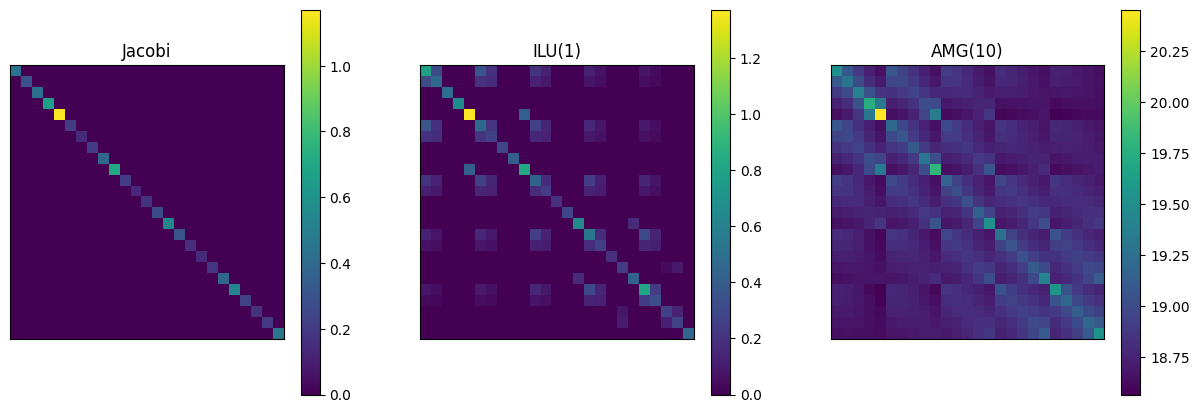

In [28]:
jac, ilu, amg = scipy.get_traditional_preconditioners(**trad_precond_params)

In [29]:
scipy.check_conditioning(data, np.eye(25), 0)
scipy.check_conditioning(data, jac, 0)
scipy.check_conditioning(data, ilu, 0)
scipy.check_conditioning(data, amg, 0)

Condition: 11745.455618057402
Condition: 11953.201434266472
Condition: 6646.172954686495
Condition: 25.000000033785227


# Torch Conjugate Gradient

Using library to do batched conjugate gradient for conjugate gradient.

In [18]:
from torch_cg.torch_cg import cg_batch

In [19]:
A, b = next(iter(valid_dataloader)) 
A = A.to(device)
out = model(A.view(Config.batch_size, Config.mat_size * Config.mat_size)).view(Config.batch_size, Config.mat_size, Config.mat_size)
A, out = A.cpu(), out.detach().cpu()

In [35]:
b = torch.randn(32, 25, 1)

xs = cg_batch(lambda x: torch.matmul(A, x), b, lambda x: torch.matmul(out, x), maxiter=25, verbose=True)

 it |       dist   it/s
001 | 7.2920e+00 1695.65
002 | 5.4339e+00 2404.83
003 | 6.8512e+00 2448.31
004 | 9.3350e+00 2535.02
005 | 1.2631e+01 2532.64
006 | 1.4356e+01 2558.18
007 | 1.6237e+01 2555.50
008 | 1.9457e+01 2574.67
009 | 2.3800e+01 2576.95
010 | 2.7264e+01 2490.60
011 | 3.1385e+01 2597.04
012 | 3.6190e+01 2587.34
013 | 3.7353e+01 2619.97
014 | 3.8122e+01 2560.65
015 | 4.0684e+01 2575.29
016 | 4.2010e+01 2597.32
017 | 4.0119e+01 2352.24
018 | 3.5662e+01 2598.44
019 | 3.3948e+01 2667.90
020 | 3.5771e+01 2645.39
021 | 3.6833e+01 2643.00
022 | 3.7394e+01 2657.95
023 | 3.7669e+01 2649.60
024 | 3.7747e+01 2669.34
025 | 3.7976e+01 2558.21
Terminated in 25 steps (optimal). Took 13.794 ms.


In [37]:
# Don't need to worry about he indifference in the solving times because this should make the difference.
# If not optimal, all get 0 and just using (sparsity measure + residual norms). 
# If optimal, get (niter + sparsity measure + residual norms).
xs[0].shape, xs[1]

(torch.Size([32, 25, 1]),
 {'niter': 25,
  'optimal': False,
  'last_residual': tensor([[ 4.0049],
          [ 2.6494],
          [ 9.3123],
          [21.1752],
          [12.2063],
          [ 2.6410],
          [ 3.7400],
          [23.3683],
          [ 7.6992],
          [12.2111],
          [ 9.0227],
          [ 0.4155],
          [ 4.0265],
          [ 1.9924],
          [23.1611],
          [ 0.6084],
          [12.6835],
          [21.3835],
          [19.2356],
          [ 1.0631],
          [ 2.3223],
          [16.6067],
          [ 5.4890],
          [14.7171],
          [37.6786],
          [ 7.1517],
          [37.9813],
          [29.6184],
          [ 0.6190],
          [11.7039],
          [ 2.0029],
          [ 2.8418]])})

In [24]:
xs[-1]['last_residual'].shape

torch.Size([32, 1])

In [66]:
torch.linalg.norm(A @ xs[0] - b, dim=1)

tensor([[59.2128],
        [ 7.0464],
        [ 2.1140],
        [30.2224],
        [ 0.2365],
        [35.4022],
        [ 2.7023],
        [12.5131],
        [13.3756],
        [ 5.7883],
        [14.3181],
        [ 7.7976],
        [ 3.8189],
        [ 4.3380],
        [ 3.4871],
        [25.0654],
        [ 6.7553],
        [ 1.7190],
        [ 5.8724],
        [27.9558],
        [ 6.5007],
        [15.5029],
        [22.5655],
        [ 1.2364],
        [17.9347],
        [ 8.5124],
        [28.9582],
        [16.6276],
        [18.8488],
        [ 4.0766],
        [ 2.3700],
        [ 3.1134]])